## **Setting Up SharePoint Integration (Tool) with Azure AI Agents**

> ⚠️ **Feature In Public Preview**  

### **📝 Overview**

SharePoint can be used as a secure data source to ground your Azure AI Agents with documents stored in SharePoint. For example, you can connect to a SharePoint site like `contoso.sharepoint.com/sites/policies`. When a user sends a query, Azure AI Agents will determine whether SharePoint should be leveraged. If so, the query is sent via the SharePoint tool, which:

1. Verifies if the user has an M365 Copilot license.
2. Uses the end user's identity to retrieve relevant documents they have access to.
3. Generates responses based on the retrieved information.

With SharePoint integration, **On-Behalf-Of (OBO)** authentication is supported, allowing the SharePoint tool to retrieve documents based on the end user's identity and access.

### **✅ Prerequisites**

Before you begin, ensure the following:

1. **Existing SharePoint Site**: Developers must have access to the SharePoint site.
2. **M365 Copilot Licenses**: Both developers and end users must have M365 Copilot licenses.

🔑 Role-Based Access Control (RBAC) Requirements

- **For Developers**: Must have the **AI Developer** role to create, read, update, or delete (CRUD) a SharePoint tool in Azure AI Agent.
- **For End Users**: Must have the **AI Developer** role to enable On-Behalf-Of (OBO) authentication.

### **🛠️ How-To Guide**

1️⃣ Verify Access to the Existing SharePoint Site: Ensure developers have the necessary permissions to access the SharePoint site:

1. Navigate to the SharePoint site.
2. Click on the gear icon (⚙️) in the top-right corner and select **"Site Permissions"**.
3. Choose **"Advanced Permission Settings"**.
4. Click on **"Check Permissions"** in the ribbon.
5. Enter the developer's username or email and click **"Check Now"**.
6. Review the permissions to ensure they have appropriate access.

2️⃣ Confirm M365 Copilot Licenses for Developers and End Users: Both developers and end users must have M365 Copilot licenses. Follow these steps to verify:

**For Administrators:**
1. Sign in to [Microsoft Admin Center](https://admin.microsoft.com/) with an admin account.
2. Navigate to **Billing > Licenses** to view available licenses.  
   👉 [Learn more about licensing requirements](https://learn.microsoft.com/en-us/microsoft-copilot-studio/requirements-licensing).
3. Go to **Users > Active Users**.
4. Select a user and click on **Licenses and Apps**.
5. Ensure the **M365 Copilot** license is assigned.

**Option 1: Check via Microsoft Account Portal**
1. Go to [Microsoft Account Portal](https://myaccount.microsoft.com/).
2. On the left sidebar, check:
   - **My Apps** → Look for M365 Copilot.
   - **My Access** → This may show assigned licenses.
   - **My Groups** → If there is an M365 Copilot group, you might be assigned a license through it.
3. If you see **My Subscriptions** or **Licenses**, click it to check if the **M365 Copilot** license is assigned to you.

> **Tip**: If you can’t find your license, contact your IT department or Microsoft 365 administrator to verify.

3.  Assign Appropriate RBAC Roles

Proper RBAC roles are essential for managing SharePoint tools in Azure AI Agent.

**For Developers:**
- Must have the **AI Developer** role to CRUD a SharePoint tool.

**For End Users:**
- Must have the **AI Developer** role to enable OBO authentication.

**Steps to Assign Roles:**
1. Go to [Azure Portal](https://portal.azure.com/).
2. Navigate to **Subscriptions** and select your subscription.
3. Click on **Access Control (IAM)** > **Add Role Assignment**.
4. Choose the **AI Developer** role.
5. Select the users or groups to assign the role to and click **Save**.

Once you've completed these steps..

1. **Create a New Connection**
   - Provide the required key-value pairs for the connection:
   - **`resource-key`**: Your Bing resource key.
   - **`endpoint`**: Your Bing search endpoint (typically provided in your resource details).

2. **Add a Knowledge Source**
   - Click to add a knowledge source and select **Grounding with Bing Search** (UI) or run code below.
   - If
      - Ensure you have the necessary permissions.

In [11]:
import os

from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Define the target directory
target_directory = os.getcwd()  # Get the current working directory

# Move one directory back
parent_directory = os.path.dirname(target_directory)

# Check if the parent directory exists
if os.path.exists(parent_directory):
    # Change the current working directory to the parent directory
    os.chdir(parent_directory)
    print(f"Directory changed to {os.getcwd()}")
else:
    print(f"Parent directory {parent_directory} does not exist.")

Directory changed to c:\Users\pablosal\Desktop


In [2]:
import importlib.metadata as md

# Versions - we are currently 1.0.0b9 of azure-ai-projects
print("semantic-kernel version:", md.version("semantic-kernel"))
print("azure-ai-projects version:", md.version("azure-ai-projects"))
# if you want to Upgrade the SDKs, uncomment the line below but code might break
# %pip install -U semantic-kernel azure-ai-projects azure-identity

semantic-kernel version: 1.28.1
azure-ai-projects version: 1.0.0b9


In [12]:
import os
import re
import time
import logging
import json
from datetime import datetime as pydatetime
from typing import Any, List, Dict, Optional
from dotenv import load_dotenv
import asyncio
from datetime import timedelta

# Azure AI Projects
from azure.identity.aio import DefaultAzureCredential
from azure.core.exceptions import HttpResponseError

# semantic kernel
from semantic_kernel.contents import AuthorRole
from semantic_kernel.agents.azure_ai.azure_ai_agent import (
    AzureAIAgent,
    AzureAIAgentSettings,
)
from semantic_kernel.agents.open_ai.run_polling_options import RunPollingOptions

# Load environment variables from .env file
load_dotenv()

# configure logging
from utils.ml_logging import get_logger

logger = get_logger()

In [13]:
import os
import json
import logging
from typing import Set, Tuple, Optional
from azure.core.exceptions import ServiceRequestError
from azure.identity import DefaultAzureCredential
from azure.ai.projects import AIProjectClient


def process_citations(text_msg) -> str:
    """
    Given a text_message with .text.value and .text.annotations, append a
    **Citations** section with unique URL citations.
    """
    base = text_msg.text.value
    seen: Set[Tuple[str, str]] = set()

    for annot in getattr(text_msg.text, "annotations", []):
        uc = getattr(annot, "url_citation", None)
        if uc and uc.url:
            seen.add((annot.text, uc.url))

    if seen:
        base += "\n\n**Citations:**\n"
        for quote, url in seen:
            base += f"- **Quote**: {quote}  \n"
            base += f"  **URL**: [{url}]({url})\n"

    return base


def run_agent(
    project_client: AIProjectClient, agent_id: str, user_input: str
) -> Tuple[str, str]:
    """
    Synchronously:
      1) opens a new thread
      2) posts user_input
      3) runs the agent (blocking)
      4) collects & enriches all replies
    Returns (conversation_text, thread_id).
    """
    # 1️⃣ create thread & send the question
    thread = project_client.agents.create_thread()
    project_client.agents.create_message(
        thread_id=thread.id, role="user", content=user_input
    )

    # 2️⃣ run & wait
    project_client.agents.create_and_process_run(thread_id=thread.id, agent_id=agent_id)

    # 3️⃣ fetch and format all messages
    convo = f"👤 User: {user_input}\n"
    page = project_client.agents.list_messages(thread_id=thread.id)

    # the sync pager exposes .data for the list of message objects
    messages = page.data if hasattr(page, "data") else list(page)
    for msg in messages:
        # each msg has .text_messages, a list of text fragments / annotations
        for text_msg in getattr(msg, "text_messages", []):
            enriched = process_citations(text_msg)
            convo += f"\n🤖 {agent_id}: {enriched}\n"

    return convo, thread.id

### **Create Client and Load Azure AI Foundry**

Here, we initialize the Azure AI client using DefaultAzureCredential. This allows us to authenticate and connect to the Azure AI service.

In [14]:
project_client = AIProjectClient.from_connection_string(
    credential=DefaultAzureCredential(),
    conn_str=os.environ["AZURE_AI_FOUNDRY_CONNECTION_STRING"],
)

In [15]:
from azure.ai.projects.models import (
    SharepointTool,
    ToolSet,
)


def get_connection_id(client: AIProjectClient, env_var: str) -> Optional[str]:
    """
    Retrieves the connection object using a connection name stored in an environment variable.

    Args:
        client: The Azure AI Project client.
        env_var (str): The environment variable holding the connection name.

    Returns:
        Connection object if found, otherwise raises an error.
    """
    connection_name = os.getenv(env_var)
    if not connection_name:
        logger.error(f"Missing environment variable: '{env_var}'")
        raise ValueError(f"Environment variable '{env_var}' is required.")

    try:
        connection = client.connections.get(connection_name=connection_name)
        logger.info(f"Retrieved Connection ID for {env_var}: {connection.id}")
        return connection
    except Exception as e:
        logger.error(f"Failed to retrieve connection for {env_var}: {e}")
        raise


# Initialize Azure AI Agent settings
dataretrievalagent_settings = AzureAIAgentSettings.create()

toolset = ToolSet()

try:
    # Retrieve and add SharePoint Tool
    sharepoint_connection = get_connection_id(
        project_client, "TOOL_CONNECTION_NAME_SHAREPOINT"
    )
    toolset.add(SharepointTool(connection_id=sharepoint_connection.id))

    logger.info("Successfully created ToolSet with SharePoint and Fabric tools.")
except Exception as e:
    logger.error(f"Failed to create ToolSet: {e}")
    raise

2025-06-24 23:25:32,281 - micro - MainProcess - INFO     Retrieved Connection ID for TOOL_CONNECTION_NAME_SHAREPOINT: /subscriptions/47f1c914-e299-4953-a99d-3e34644cfe1c/resourceGroups/rg-zhuoqunliai/providers/Microsoft.MachineLearningServices/workspaces/zhuoqunli-1959/connections/ContosoAgentDemoSharepoint (1927046953.py:get_connection_id:25)
INFO:micro:Retrieved Connection ID for TOOL_CONNECTION_NAME_SHAREPOINT: /subscriptions/47f1c914-e299-4953-a99d-3e34644cfe1c/resourceGroups/rg-zhuoqunliai/providers/Microsoft.MachineLearningServices/workspaces/zhuoqunli-1959/connections/ContosoAgentDemoSharepoint
2025-06-24 23:25:32,289 - micro - MainProcess - INFO     Successfully created ToolSet with SharePoint and Fabric tools. (1927046953.py:<module>:44)
INFO:micro:Successfully created ToolSet with SharePoint and Fabric tools.


In [17]:
import os
import json
import logging
from typing import Set, Tuple, Optional
from azure.core.exceptions import ServiceRequestError
from azure.identity import DefaultAzureCredential
from azure.ai.projects.aio import AIProjectClient


def process_citations(text_msg) -> str:
    """
    Given a text_message with .text.value and .text.annotations, append a
    **Citations** section with unique URL citations.
    """
    base = text_msg.text.value
    seen: Set[Tuple[str, str]] = set()

    for annot in getattr(text_msg.text, "annotations", []):
        uc = getattr(annot, "url_citation", None)
        if uc and uc.url:
            seen.add((annot.text, uc.url))

    if seen:
        base += "\n\n**Citations:**\n"
        for quote, url in seen:
            base += f"- **Quote**: {quote}  \n"
            base += f"  **URL**: [{url}]({url})\n"

    return base


def run_agent(
    project_client: AIProjectClient, agent_id: str, user_input: str
) -> Tuple[str, str]:
    """
    • Posts `user_input` to a new thread on `agent_id`.
    • Blocks until the run completes.
    • Gathers only the *real* assistant replies, enriches with citations.
    Returns (conversation_text, thread_id).
    """
    # 1) create thread & send question
    thread = project_client.agents.create_thread()
    project_client.agents.create_message(
        thread_id=thread.id, role="user", content=user_input
    )

    # 2) run & wait
    project_client.agents.create_and_process_run(thread_id=thread.id, agent_id=agent_id)

    # 3) collect & enrich only true assistant messages
    convo = f"👤 User: {user_input}\n"
    pager = project_client.agents.list_messages(thread_id=thread.id)
    messages = pager.data if hasattr(pager, "data") else list(pager)

    for msg in messages:
        # only look at assistant turns
        if msg.role.lower() != "assistant":
            continue

        for text_msg in getattr(msg, "text_messages", []):
            content = text_msg.text.value.strip()

            # skip exact echoes of the prompt
            if content == user_input.strip():
                continue

            enriched = process_citations(text_msg)
            convo += f"\n🤖 Assistant: {enriched}\n"

    return convo, thread.id

In [18]:
dataretrievalagent_settings_definition = project_client.agents.create_agent(
    model=dataretrievalagent_settings.model_deployment_name,
    name="SharePointDataRetrievalAgent",
    description=(
        "An AI agent specialized in retrieving and analyzing unstructured documents from SharePoint. "
        "This includes research papers, legal documents, and product engineering files (PDFs). "
        "The agent is designed to assist in research and development by providing accurate, relevant, and actionable insights. "
        "If no relevant data is found, the agent must clearly indicate this and provide suggestions for alternative queries or data sources."
    ),
    instructions=(
        "### Role & Objective\n"
        "You are a research-focused AI assistant responsible for retrieving and analyzing unstructured documents exclusively from SharePoint. "
        "Your goal is to provide precise, well-referenced, and relevant responses to support research and development, legal analysis, and product engineering efforts.\n\n"
        "### Data Retrieval & Prioritization\n"
        "1. **Unstructured Data (SharePoint):** \n"
        "   - Retrieve documents from SharePoint when the query involves research papers, legal documents, or product engineering files (PDFs).\n"
        "   - Focus on extracting key insights, summaries, and actionable information from the retrieved documents.\n"
        "   - Example: 'Retrieve research papers on Material X used in high-temperature environments,' or 'Find legal documents related to patent filings for Product A.'\n\n"
        "2. **Document Types:** \n"
        "   - Research Papers: Summarize findings, methodologies, and conclusions.\n"
        "   - Legal Documents: Extract key clauses, compliance requirements, and patent-related information.\n"
        "   - Product Engineering Files: Highlight design notes, test results, and engineering decisions.\n\n"
        "3. **Integrated Queries:** \n"
        "   - If the query spans multiple document types, retrieve and integrate the results for a comprehensive response.\n"
        "   - Ensure clarity in presenting combined insights.\n\n"
        "4. **Fallback Behavior:** \n"
        "   - If no relevant data is found in SharePoint, respond with:\n"
        "     - A clear statement that no relevant data was found.\n"
        "     - Suggestions for alternative queries or data sources (if applicable).\n"
        "     - Example: 'No relevant data was found for the requested query in SharePoint. Consider refining your query or exploring other data sources.'\n\n"
        "### Response Quality\n"
        "1. **Accuracy & Relevance:** Always prioritize retrieving the most current and applicable documents from SharePoint.\n"
        "2. **Clarity & Transparency:** Clearly indicate the data source(s) used and any limitations in the available information.\n"
        "3. **Fallback Handling:** If no relevant data is found, provide a professional and helpful fallback response as outlined above.\n"
        "4. **Professionalism:** Present findings in a structured and concise manner to facilitate decision-making.\n"
        "5. **Document Context:** Ensure that extracted insights are presented with sufficient context to maintain their relevance and accuracy.\n"
    ),
    toolset=toolset,
    headers={"x-ms-enable-preview": "true"},
    temperature=0.7,
    top_p=1,
    metadata={
        "use_case": "Unstructured Data Retrieval for R&D, Legal, and Engineering",
        "data_source": "SharePoint",
    },
)

# Print the agent's run ID (agent ID)
print(
    f"SharePointDataRetrievalAgent Run ID: {dataretrievalagent_settings_definition.id}"
)

SharePointDataRetrievalAgent Run ID: asst_S0hdvZFiiBDBLZQLpewl1eWE


In [23]:
user_query = "In which glucose ranges does Product A underperform compared to Product B, and what clinical impact could this have?"
sharepoint_response, threadID = run_agent(
    project_client, "asst_S0hdvZFiiBDBLZQLpewl1eWE", user_query
)

In [24]:
print(sharepoint_response)

👤 User: In which glucose ranges does Product A underperform compared to Product B, and what clinical impact could this have?

🤖 Assistant: Product A underperforms compared to Product B in glucose measurement accuracy by consistently recording lower glucose levels than a reference glucometer, whereas Product B tends to overestimate glucose levels【3:1†source】. This discrepancy could pose significant clinical impacts, particularly in insulin dosing decisions. Underestimation of glucose levels by Product A could lead to inappropriate insulin administration, increasing the risk of hypoglycemia. Conversely, the overestimation by Product B might result in insufficient insulin dosing, potentially leading to hyperglycemia. These inaccuracies emphasize the importance of clinicians and users being cautious when interpreting CGM data, especially in critical situations where precise glucose control is necessary【3:1†source】.

**Citations:**
- **Quote**: 【3:1†source】  
  **URL**: [https://microsoft.s

The agent was capable to find the right information from our Sharepoint Site !!


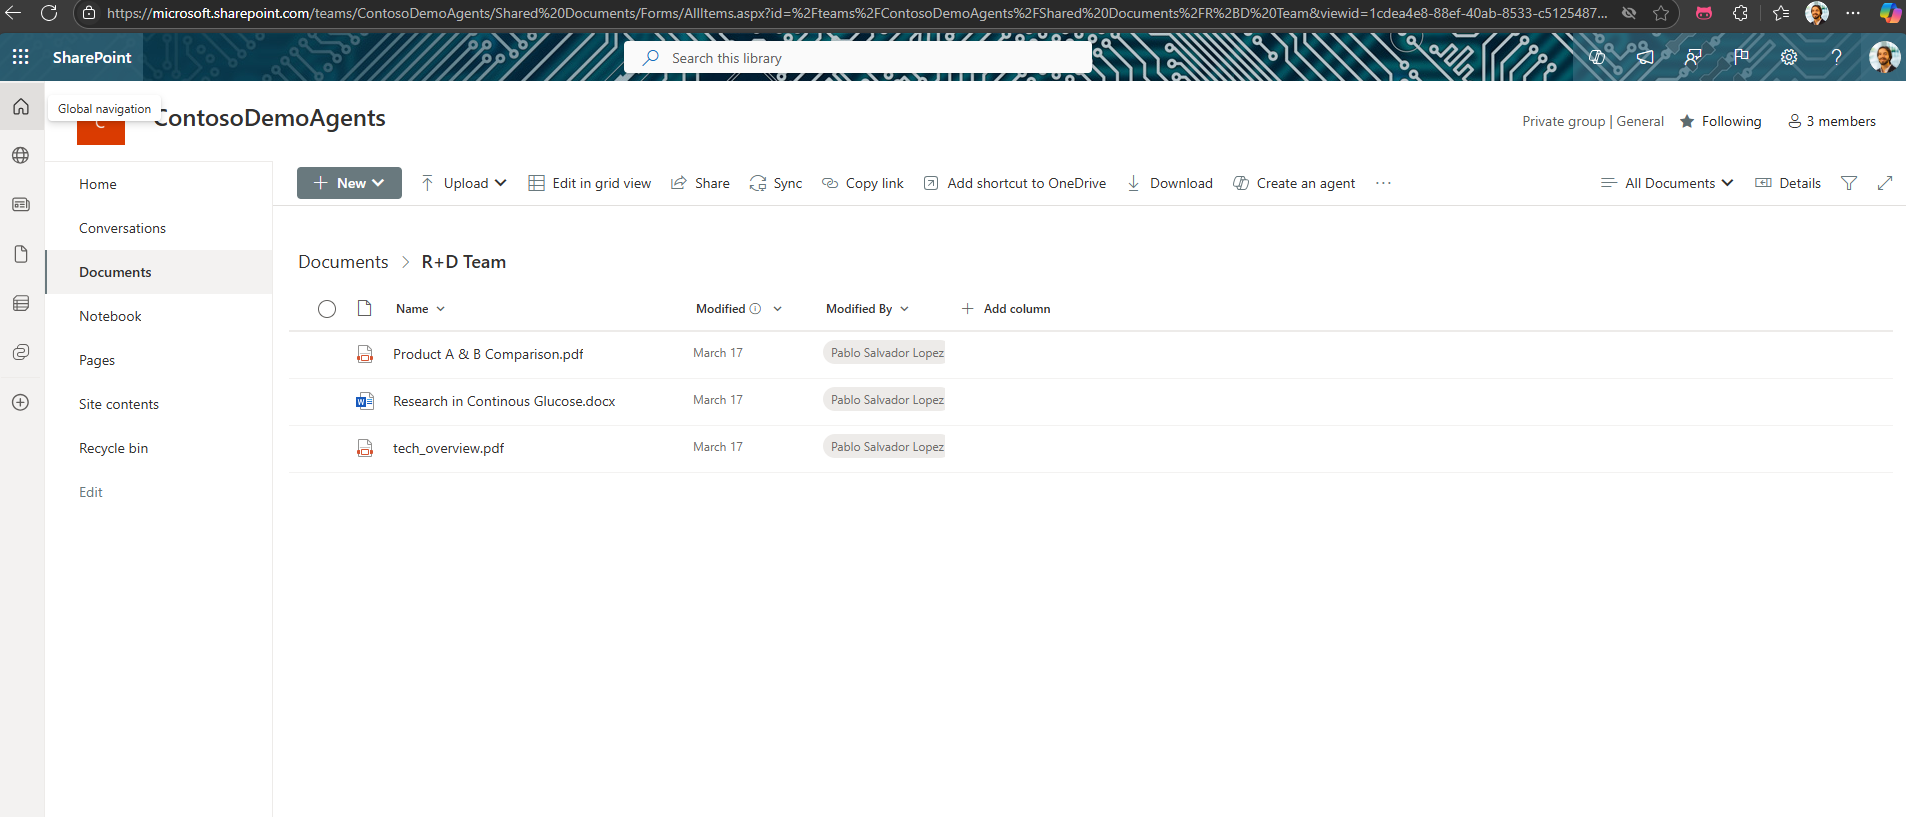